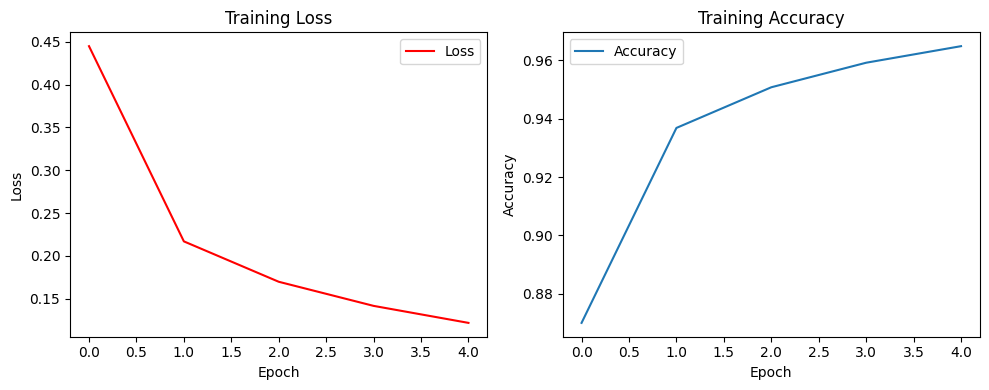

Epoch 5/10 — Loss: 0.1218 — Accuracy: 96.48%


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

BATCH_SIZE = 64
EPOCHS = 10
LEARNING_RATE = 0.01

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    transforms.Lambda(lambda x: x.view(-1))
])

train_dataset = datasets.MNIST(root='dataset', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='dataset', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

class Scratch:
    def __init__(self):
        self.w1 = np.random.randn(256, 784) * np.sqrt(2 / 784)
        self.b1 = np.zeros((1, 256))

        self.w2 = np.random.randn(64, 256) * np.sqrt(2 / 256)
        self.b2 = np.zeros((1, 64))

        self.w3 = np.random.randn(10, 64) * np.sqrt(2 / 64)
        self.b3 = np.zeros((1, 10))

    @staticmethod
    def relu(z):
        return np.maximum(0, z)

    @staticmethod
    def relu_derivative(z):
        return (z > 0).astype(float)

    def forward(self, x):
        self.x = x 
        self.z1 = x @ self.w1.T + self.b1
        self.a1 = self.relu(self.z1)

        self.z2 = self.a1 @ self.w2.T + self.b2
        self.a2 = self.relu(self.z2)

        self.z3 = self.a2 @ self.w3.T + self.b3
        return self.z3

    @staticmethod
    def softmax(z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    @staticmethod
    def cross_entropy_loss(logits, labels):
        logits_stable = logits - np.max(logits, axis=1, keepdims=True)
        log_sum_exp = np.log(np.sum(np.exp(logits_stable), axis=1, keepdims=True))
        loss_per_sample = -np.sum(labels * (logits_stable - log_sum_exp), axis=1)
        return np.mean(loss_per_sample)

    def backward(self, logits, labels, learning_rate=0.01):
        N = labels.shape[0]
        probs = self.softmax(logits)
        dL_dz3 = (probs - labels) / N

        dL_dw3 = dL_dz3.T @ self.a2
        dL_db3 = np.sum(dL_dz3, axis=0, keepdims=True)

        dL_da2 = dL_dz3 @ self.w3
        dL_dz2 = dL_da2 * self.relu_derivative(self.z2)

        dL_dw2 = dL_dz2.T @ self.a1
        dL_db2 = np.sum(dL_dz2, axis=0, keepdims=True)

        dL_da1 = dL_dz2 @ self.w2
        dL_dz1 = dL_da1 * self.relu_derivative(self.z1)

        dL_dw1 = dL_dz1.T @ self.x
        dL_db1 = np.sum(dL_dz1, axis=0, keepdims=True)

        self.w3 -= learning_rate * dL_dw3
        self.b3 -= learning_rate * dL_db3

        self.w2 -= learning_rate * dL_dw2
        self.b2 -= learning_rate * dL_db2

        self.w1 -= learning_rate * dL_dw1
        self.b1 -= learning_rate * dL_db1


model = Scratch()
train_losses, train_accuracies = [], []

for epoch in range(EPOCHS):
    epoch_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.numpy()
        labels_onehot = np.zeros((labels.shape[0], 10))
        labels_onehot[np.arange(labels.shape[0]), labels.numpy()] = 1

        logits = model.forward(images)
        loss = model.cross_entropy_loss(logits, labels_onehot)
        model.backward(logits, labels_onehot, learning_rate=LEARNING_RATE)

        epoch_loss += loss * labels.shape[0]

        preds = np.argmax(logits, axis=1)
        correct += (preds == labels.numpy()).sum()
        total += labels.shape[0]

    avg_loss = epoch_loss / total
    acc = correct / total
    train_losses.append(avg_loss)
    train_accuracies.append(acc)

    clear_output(wait=True)
    plt.figure(figsize=(10,4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Loss", color="red")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label="Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f"Epoch {epoch+1}/{EPOCHS} — Loss: {avg_loss:.4f} — Accuracy: {acc * 100:.2f}%")
